### Imports

In [18]:
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Read Data to evaluate

In [19]:
eval_df = pd.read_csv("../data/evaluation/evaluation-features.csv", dtype={"url": str})
gpt_df = pd.read_csv("../data/evaluation/chatgpt-evaluation-results.csv", dtype={"url": str})

eval_df = eval_df[["url", "label"]].copy()
gpt_df = gpt_df[["url", "label"]].copy()

eval_df["label"] = eval_df["label"].astype(int)
gpt_df["label"] = gpt_df["label"].astype(int)

In [20]:
# Check if there are URLs with different labels in the same file.
conflicts_eval = (eval_df.groupby("url")["label"].nunique() > 1).sum()
conflicts_gpt = (gpt_df.groupby("url")["label"].nunique() > 1).sum()

print("Conflict-URLs in eval_df :", conflicts_eval)
print("Conflict-URLs in black_df:", conflicts_gpt)


Conflict-URLs in eval_df : 0
Conflict-URLs in black_df: 0


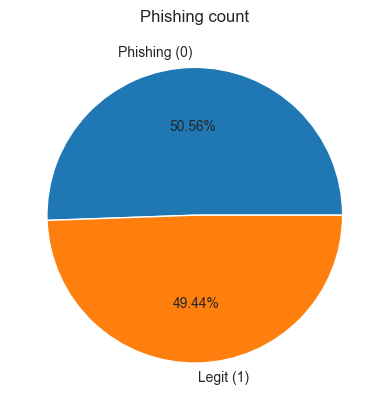

In [21]:
counts = eval_df['label'].value_counts()
counts = counts.rename(index={0: 'Phishing (0)', 1: 'Legit (1)'})
counts.plot(kind='pie', autopct='%1.2f%%')
plt.title("Phishing count")
plt.ylabel('')
plt.show()

### Evaluate ChatGPT

In [22]:
# Merge Files by URLs to calculate evaluation metrics
merged = (
    eval_df.rename(columns={"label": "true_label"})
    .merge(
        gpt_df.rename(columns={"label": "pred_label"}),
        on="url",
        how="inner"
    )
)

print(f"Number of gpt URLs: {len(gpt_df)}")
print(f"Number of evaluation URLs: {len(eval_df)}")
print(f"Number of matched URLs: {len(merged)}")

y_evaluation_features = merged["true_label"].to_numpy()
y_gpt_results   = merged["pred_label"].to_numpy()

Number of gpt URLs: 54270
Number of evaluation URLs: 54270
Number of matched URLs: 54270


In [23]:
acc_eval_blc = metrics.accuracy_score(y_evaluation_features, y_gpt_results)
print("GPT : Accuracy on evaluation Data: {:.4f}".format(acc_eval_blc))

GPT : Accuracy on evaluation Data: 0.6425


In [24]:
print(metrics.classification_report(y_evaluation_features, y_gpt_results, digits=4, target_names=["Phishing(0)", "Legit(1)"]))

              precision    recall  f1-score   support

 Phishing(0)     0.6697    0.5780    0.6204     27439
    Legit(1)     0.6214    0.7084    0.6621     26831

    accuracy                         0.6425     54270
   macro avg     0.6455    0.6432    0.6413     54270
weighted avg     0.6458    0.6425    0.6410     54270



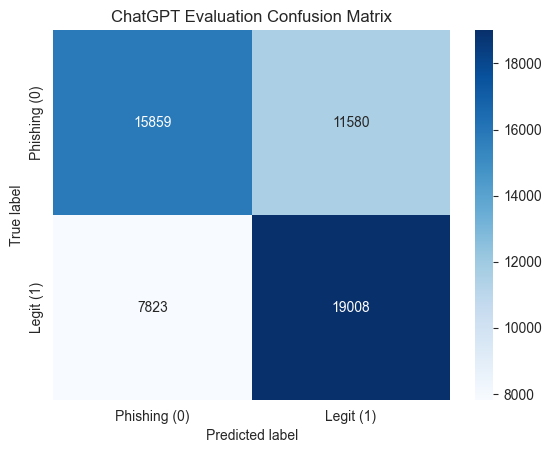

In [25]:
gpt_conf_matrix = metrics.confusion_matrix(y_evaluation_features, y_gpt_results)
labels = ['Phishing (0)', 'Legit (1)']

sns.heatmap(gpt_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('ChatGPT Evaluation Confusion Matrix')
plt.show()


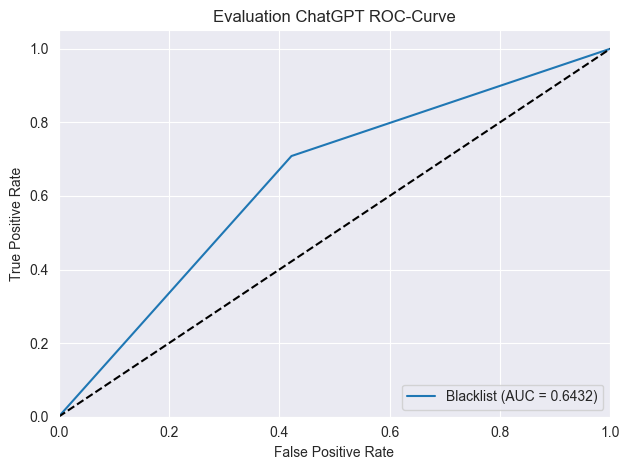

In [26]:
fpr, tpr, thresholds = metrics.roc_curve(
    y_evaluation_features,
    y_gpt_results,
    pos_label=1
)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Blacklist (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Evaluation ChatGPT ROC-Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()